#### Maps of surface precipitation in prognostic runs for baseline physics, RF, and NN ensemble

In [1]:
# %matplotlib inline

import matplotlib.pyplot as plt

import cftime
import intake
import fsspec
import numpy as np
import pandas as pd
import seaborn as sb
import xarray as xr
import string

import fv3viz as viz
from vcm.catalog import catalog
from vcm.fv3.metadata import standardize_fv3_diagnostics

def weighted_average(array, weights, axis=None):
    return np.nansum(array * weights, axis=axis) / np.nansum(weights, axis=axis)


MAPPABLE_VAR_KWARGS = {
    "coord_x_center": "x",
    "coord_y_center": "y",
    "coord_x_outer": "x_interface",
    "coord_y_outer": "y_interface",
    "coord_vars": {
        "lonb": ["y_interface", "x_interface", "tile"],
        "latb": ["y_interface", "x_interface", "tile"],
        "lon": ["y", "x", "tile"],
        "lat": ["y", "x", "tile"],
    },
}

SECONDS_PER_DAY = 86400

with fsspec.open("gs://vcm-ml-public/argo/prog-report-nudge-to-3km-nn-rf-comparison/NN ensemble/diags.nc", "rb") as f:
    diags_nn = xr.open_dataset(f).load()
    
with fsspec.open("gs://vcm-ml-public/argo/prog-report-nudge-to-3km-nn-rf-comparison/random forest/diags.nc", "rb") as f:
    diags_rf = xr.open_dataset(f).load()
    
with fsspec.open("gs://vcm-ml-public/argo/prog-report-nudge-to-3km-nn-rf-comparison/baseline/diags.nc", "rb") as f:
    diags_baseline = xr.open_dataset(f).load()
    
    
grid = catalog["grid/c48"].read()
area = grid["area"]

land_sea_mask = catalog["landseamask/c48"].read()["land_sea_mask"]

#### RMSE maps (reproduces the prognostic report)

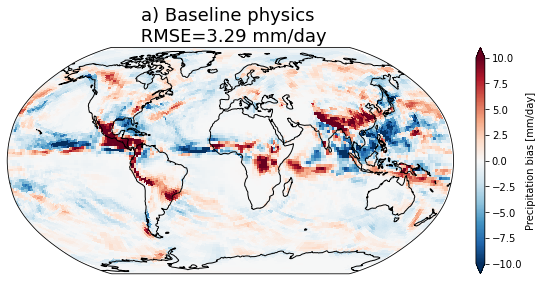

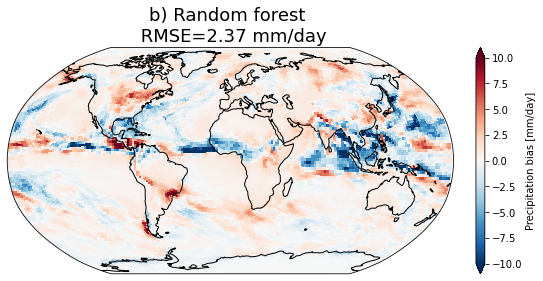

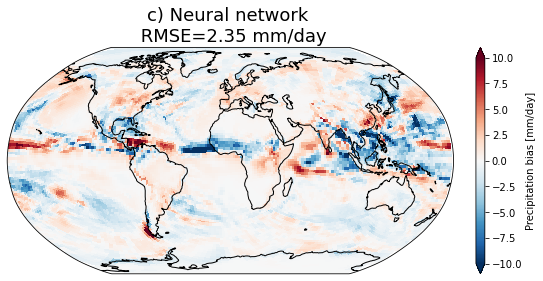

In [2]:
var = "total_precip_to_surface_time_mean_bias"
vmax = 10
fig_size = (8,5)

labels = ["Baseline physics", "Random forest", "Neural network"]
datasets = [diags_baseline, diags_rf, diags_nn]

for i, (label, ds) in enumerate(zip(labels, datasets)):
    mappable_var = viz.mappable_var(ds, var, **MAPPABLE_VAR_KWARGS)
    
    rmse = np.sqrt(weighted_average(ds[var]**2, area))
    bias = weighted_average(ds[var], area)
    
    fig, axes, _, _, _ = viz.plot_cube(
        mappable_var,
        vmax=vmax,
        cbar_label="Precipitation bias [mm/day]",
    )
    
    fig.set_size_inches(fig_size)
    
    title = f"{string.ascii_lowercase[i]}) {label} \n RMSE={rmse:3.2f} mm/day"
    plt.title(title, fontsize=18)
    plt.savefig(f"figures/prognostic-sfc-precip-rmse-map-{label.replace(' ', '-').lower()}.png", bbox_inches = "tight", dpi=500)
#     plt.show()
    

#### Bar plot for domain averages of precip bias and RMSE

In [3]:
verif_physics =  standardize_fv3_diagnostics(catalog['40day_c48_gfsphysics_15min_may2020'].to_dask())
verif_physics["total_precip_to_surface"] = verif_physics["PRATEsfc"] * SECONDS_PER_DAY

In [4]:
var= "total_precip_to_surface_time_mean_bias"

domain_avg_biases = []

labels = ["baseline", "neural network", "random forest"]
datasets = [diags_baseline, diags_nn, diags_rf]

for domain in ["global", "land", "ocean"]:
    for label, ds in zip(labels, datasets):
        if domain == "global":
            area_masked = area
            da = ds[var]
        elif domain == "land":
            area_masked = area.where(land_sea_mask==1)
            da = ds[var].where(land_sea_mask==1)
        elif domain == "ocean":
            area_masked = area.where(land_sea_mask==0)
            da = ds[var].where(land_sea_mask==0)            
        bias = ((da * area_masked).sum(skipna=True, dim=["tile", "x", "y"]) / area_masked.sum(skipna=True)).item()
        rmse = np.sqrt( 
            (da**2 * area_masked).sum(skipna=True, dim=["tile", "x", "y"]) / area_masked.sum(skipna=True)
        ).item()        
        domain_avg_biases.append([domain, label, rmse, bias])
        
biases = pd.DataFrame(domain_avg_biases, columns=["domain", "dataset", "RMSE", "bias"])


In [5]:
biases = pd.DataFrame(domain_avg_biases, columns=["domain", "dataset", "RMSE", "bias"])
biases

,domain,dataset,RMSE,bias
0,global,baseline,3.288139,-0.103885
1,global,neural network,2.353752,-0.212509
2,global,random forest,2.368011,-0.044948
3,land,baseline,4.178438,0.967052
4,land,neural network,1.924047,-0.026757
5,land,random forest,2.081575,0.304755
6,ocean,baseline,2.931559,-0.555902
7,ocean,neural network,2.576399,-0.290403
8,ocean,random forest,2.546647,-0.199308


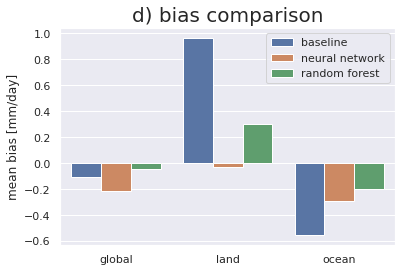

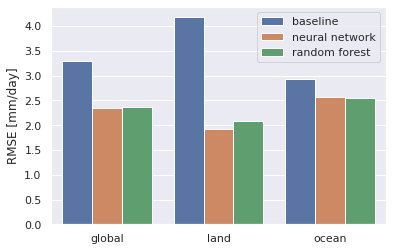

In [7]:

sb.set(font_scale = 1)


biases = pd.DataFrame(domain_avg_biases, columns=["domain", "dataset", "RMSE", "bias"])

fig, ax = plt.subplots(1, 1)
f = sb.barplot(
    x="domain", 
    y="bias", 
    hue="dataset", 
    data=biases,
)
ax.set_title('d) bias comparison', fontsize=20)
f.set_xlabel("", fontsize=20)
f.set_ylabel("mean bias [mm/day]")
f.legend(loc="upper right")
fig.savefig(f"figures/prognostic_sfc_precip_bias_bar_plot.png")


fig, ax = plt.subplots(1, 1)
f = sb.barplot(
    x="domain", 
    y="RMSE", 
    hue="dataset", 
    data=biases,
)
f.set_xlabel("", fontsize=20)
f.set_ylabel("RMSE [mm/day]")
f.legend(loc="upper right")
fig.savefig(f"figures/prognostic_sfc_precip_rmse_bar_plot.png")

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


baseline = mpimg.imread("figures/prognostic_sfc_precip_rmse_map_baseline_physics.png")
rf = mpimg.imread("figures/prognostic_sfc_precip_rmse_map_random_forest.png")
nn = mpimg.imread("figures/prognostic_sfc_precip_rmse_map_neural_network_ensemble.png")
bar = mpimg.imread("figures/prognostic_sfc_precip_rmse_bar_plot.png")
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,2, figsize=(35,20)) 
plt.axis('off')

axarr[0][0].imshow(baseline)
axarr[0][0].set_axis_off()
axarr[0][0].text(0.05, 0.9, "a)", va='top', fontsize=32, transform=axarr[0][0].transAxes)

axarr[0][1].imshow(rf)
axarr[0][1].set_axis_off()
axarr[0][1].text(0.05, 0.9, "b)", va='top', fontsize=32, transform=axarr[0][1].transAxes)

axarr[1][0].imshow(nn)
axarr[1][0].set_axis_off()
axarr[1][0].text(0.05, 0.9, "c)", va='top', fontsize=32, transform=axarr[1][0].transAxes)


axarr[1][1].imshow(bar)
axarr[1][1].set_axis_off()
axarr[1][1].text(0.05, 0.9, "d)", va='top', fontsize=32, transform=axarr[1][1].transAxes)

plt.savefig("figures/composite_sfc_precip_pattern_error.png")